In [1]:
import sys
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import matplotlib as mpl

In [2]:
from pyimcom.config import Config, Settings as Stn
from pyimcom.coadd import Block
from pyimcom.analysis import OutImage, Mosaic
from concurrent.futures import ProcessPoolExecutor

In [3]:
from metadetect_driver import parse_driver_cfg, MetaDetectRunner

# Example Uses

#### We will run some examples of running this metadetect Driver using a 2x2 block mosaic produced by PyIMCOM

## Single Band

In [4]:
with open('../config/metadetect_default.yaml', 'r') as file:
    METADETECT_CONFIG= yaml.safe_load(file)
with open('../config/driver_default.yaml', 'r') as file:
    DEFAULT_DRIVER_CFG= yaml.safe_load(file)

### Quick explanation of the configuration files read above

1. `METADETECT_CONFIG`: This is the configuration file that goes into Metadetect. For general info about how metadetect works, see the metadetect tutorial: https://github.com/Roman-HLIS-Cosmology-PIT/tutorial-metadetect/tree/main
2. `DEFAULT_DRIVER_CFG`: This is the configuration file for the driver we have made here. The arguments are the following:
 
    - `psf_img_size`: Size of the PSF image to make. The PSF is made inside the driver from the PyIMCOM configuration.
    - `bound_size`: Sets the maximum number of pixels from the edge for which we mask objects. Example, if bound_size = 100, all detections                   that are 100 pixels from the edge of the image are discarded from the catalog.
    - `mdet_seed`: Random seed that goes into Metadetect
    - `keepcols`: What columns from the Metadetect outputs to keep. Given as a list
    - `det_bands`: What bands to use for detection. The default is to use all bands given.
    - `shear_bands`: What bands to use for shape measurement. The default is to use all bands given.
    - `layer`: What layer from the coadds to use (as a string). The default is the science layer ('SCI')
    - `max_workers`: Maximum number of workers for parallelization of multiple block. Driver code allows to parallelize if multiple blocks                     need to be processed. See https://docs.python.org/3/library/concurrent.futures.html for more details.
    - `chunksize`: Chunksize for the parallelization. See https://docs.python.org/3/library/concurrent.futures.html for more details.
    - `outdir`: The output directory to ave catalogs if you want them saved. 

In [5]:
# Read the config file from which the Mosaic was made
cfg = Config(cfg_file = '../IMCOM_data/configs/config_prod_H.json')

In [6]:
# The actual data was run somewhere else, so we have to change the config file directory where the images live
cfg.outstem = '../IMCOM_data/images/H158/output'

In [7]:
# Get the full Mosaic from PyIMCOM interface (no images are actually loaded when doing this)
mosaic = Mosaic(cfg)

### Single Block

In [8]:
# select a single block in the mosaic
blk = mosaic.outimages[0][1]

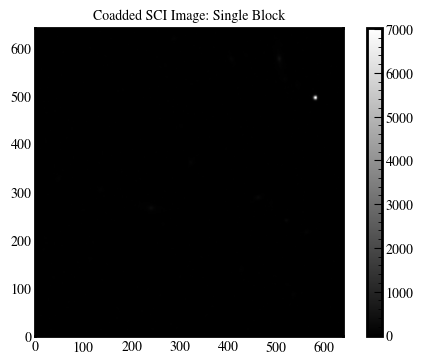

In [9]:
# Visualize Block
img = blk.get_coadded_layer('SCI')

norm = mpl.colors.Normalize()
cmap = 'gray'

fig, axs = plt.subplots(1, 1)

axs.imshow(img, norm=norm, cmap=cmap, origin='lower')
#axs.set_ylim(0,600)
#axs.set_xlim(30,100)
fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), ax=axs)
axs.set_title("Coadded SCI Image: Single Block")

plt.show()

In [10]:
# Initialize object with block
mdet_runner = MetaDetectRunner(blk, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [11]:
#### Run metadetect to get shape catalogs

In [12]:
catalogs, block_indices = mdet_runner.make_catalogs()

#### Saving outputs to disk

This will write the catalogs for each block to disk (as well as appending metadata to the table schema)

In [13]:
# Run the metadetect driver on a single
output_dir = Path('output')
mdet_runner.write_catalogs(output_dir, catalogs, block_indices, save_blocks=True)

In [14]:
for (dirpath, dirnames, filenames) in output_dir.walk():
    print(dirpath, dirnames, filenames)

output ['blocks'] ['metadetect_catalog.parquet']
output/blocks ['0'] []
output/blocks/0 [] ['metadetect_catalog_00_00.parquet']


In [15]:
for (dirpath, dirnames, filenames) in output_dir.walk():
    for filename in filenames:
        print(dirpath / filename)
    for dirname in dirnames:
        print(dirpath / dirname)

output/metadetect_catalog.parquet
output/blocks
output/blocks/0
output/blocks/0/metadetect_catalog_00_00.parquet


In [16]:
res = pq.read_table(output_dir / "metadetect_catalog.parquet")

In [17]:
res.schema.metadata

{b'package': b'metadetect_driver',
 b'version': b'0.1',
 b'galsim_version': b'2.7.2',
 b'metadetect_version': b'0.12.0',
 b'ngmix_version': b'2.4.0',
 b'pyimcom_version': b'1.0.4.dev190+ge6cf79c26'}

This may seem like few objects, but in the default settings we are removing all objects 100 pixels from the edge. You can change this by changing `bound_size` in the driver config.

### Mosaic

In [18]:
# Initialize object with mosaic
mdet_runner = MetaDetectRunner(mosaic, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [19]:
# Run the metadetect driver on a mosaic (by default runs all blocks in mosaic)
catalogs, block_indices = mdet_runner.make_catalogs()

#### You can also run individual blocks within a mosaic

To do this there are two options:
1. Pass arguments `block_rows` and `block_cols`, representing the blocks you want to run. For example passing `block_rows = 1, block_cols = 0`, means only this particular Block in the Mosaic will be processed. Alternatively you can pass a list for each one: `block_rows = [1, 0], block_cols = [0,1]`, which will run those two blocks only.
2. Pass argument `block_ids`, representing a single number ID in the Mosaic. If a Mosaic has 8 blocks on each side (nblocks = 8, 8x8 = 64 total blocks), then there is a number ID for each block. Since the indexing starts at zero, `block_ids` should be an integer (or list of integers) between [0 , nblocks^2 -1].

Only one of these two options should be passed.

In [20]:
# This only runs on block 0_1 inside the Mosaic (in PyIMCOM convention the row is the 2nd digit and column the first)
res, block_indices = mdet_runner.make_catalogs(block_rows = 1, block_cols = 0)

In [21]:
print(len(res), block_indices)

1 ([1], [0])


In [22]:
# This only runs on block 0_1 inside the Mosaic (in PyIMCOM convention the row is the 2nd digit and column the first)
res, block_indices = mdet_runner.make_catalogs(block_ids = 1)

In [23]:
print(len(res), block_indices)

1 ([1], [0])


#### Or for entire rows (or columns) in a Mosaic:
By specifying only one of block_rows and block_cols, it runs detection on all blocks in the specified rows/cols.
So for example setting block_rows = [1,2] runs detection on all blocks in rows 1 and 2. Similarly for block_cols.

In [24]:
# This only runs on block 0_1 inside the Mosaic (in PyIMCOM convention the row is the 2nd digit and column the first)
res, block_indices = mdet_runner.make_catalogs(block_rows = [1])

In [25]:
print(len(res), block_indices)

2 ([1], None)


## Multi-band

In [26]:
# Read the config file for both bands
cfg_H = Config(cfg_file = '../IMCOM_data/configs/config_prod_H.json')
cfg_J = Config(cfg_file = '../IMCOM_data/configs/config_prod_J.json')

In [27]:
cfg_H.outstem = '../IMCOM_data/images/H158/output'
cfg_J.outstem = '../IMCOM_data/images/J129/output'

In [28]:
mosaic_H = Mosaic(cfg_H)
mosaic_J= Mosaic(cfg_J)
mosaics = [mosaic_H, mosaic_J]

### Single Block

In [29]:
# select a single block in the mosaic
blks = [mosaic.outimages[0][1] for mosaic in mosaics]

In [30]:
# Initialize object with block
mdet_runner = MetaDetectRunner(blks, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [31]:
# Run the metadetect driver on a single
res, block_indices = mdet_runner.make_catalogs()

In [32]:
print(len(res), block_indices)

1 (None, None)


You may have noticed we have more objects detected. This is because Metadetect creates a multi-band coadd for detection, so we can find more objects!

### Mosaic

In [33]:
# Initialize object with mosaic
mdet_runner = MetaDetectRunner(mosaics, meta_cfg = METADETECT_CONFIG, driver_cfg = DEFAULT_DRIVER_CFG)

In [34]:
# Run the metadetect driver on a mosaic (by default runs all blocks in mosaic)
res, block_indices = mdet_runner.make_catalogs()

In [35]:
print(len(res), block_indices)

4 (None, None)
